#Eye Tracker

#####Logging

In [1]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 1.89 ms (started: 2021-05-06 11:26:02 +00:00)


In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-64dbf959-5f40-674d-604f-b0b27a3259bf)
time: 119 ms (started: 2021-05-06 11:26:02 +00:00)


##Preprocess data

###Download and decompress the data


In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from PIL import Image
import pathlib

!rm -rf sample_data
filename = 'dataset.zip'
gdd.download_file_from_google_drive(file_id='1U5_KcTyPwIyQ_vPb1kkUlULVnIBLl88N',
                                    dest_path=f'./{filename}')
!unzip -q {filename}
!rm {filename}
with Image.open('dataset/frames/0000001.jpg') as im:
  frameSize = im.size

time: 45.4 s (started: 2021-05-06 11:26:07 +00:00)


###Creating dataframes

In [4]:
import pandas as pd

trainDataframe = pd.read_csv('dataset/train.csv', delimiter=';')
testDataframe = pd.read_csv('dataset/test.csv', delimiter=';')

time: 225 ms (started: 2021-05-06 11:26:52 +00:00)


###Plotting to ensure data is useable

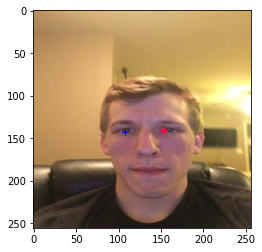

time: 256 ms (started: 2021-05-06 11:27:39 +00:00)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
row = testDataframe.iloc[np.random.randint(testDataframe.shape[0])]
with Image.open(row[0]) as im:
  plt.imshow(im)
  left = row[[1,2]]*frameSize
  right = row[[3,4]]*frameSize
  plt.plot(left[0], left[1], 'r+')
  plt.plot(right[0], right[1], 'b+')

### Creating data generator

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDatagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.01)
testDatagen = ImageDataGenerator(rescale = 1./255)
batchSize = 2048
print('Training')
trainGenerator = trainDatagen.flow_from_dataframe(
                                              dataframe = trainDataframe,
                                              x_col='image',
                                              y_col=['leftX', 'leftY', 'rightX', 'rightY'],
                                              class_mode = 'raw',
                                              target_size = frameSize,
                                              shuffle = True, 
                                              batch_size=batchSize,
                                              subset = 'training')
print('Validation')
validGenerator = trainDatagen.flow_from_dataframe(
                                              dataframe = trainDataframe,
                                              x_col='image',
                                              y_col=['leftX', 'leftY', 'rightX', 'rightY'],
                                              class_mode = 'raw',
                                              target_size = frameSize,
                                              shuffle = False, 
                                              batch_size=batchSize,
                                              subset = 'validation')
print('Testing')
testGenerator = testDatagen.flow_from_dataframe(
                                              dataframe = testDataframe,
                                              x_col='image',
                                              class_mode = None,
                                              shuffle = False,
                                              target_size = frameSize,
                                              batch_size = 1)

Training
Found 117314 validated image filenames.
Validation
Found 1184 validated image filenames.
Testing
Found 13041 validated image filenames.
time: 1.68 s (started: 2021-05-06 11:31:24 +00:00)


## Creating the model

###Construct

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Dropout

model = Sequential([
    Conv2D(8, (32,32), (8,8), input_shape = frameSize + (3,), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, (16,16), (4,4), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(4, activation='linear')
])
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_214 (Conv2D)          (None, 29, 29, 8)         24584     
_________________________________________________________________
batch_normalization_124 (Bat (None, 29, 29, 8)         32        
_________________________________________________________________
dropout_112 (Dropout)        (None, 29, 29, 8)         0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 4, 4, 16)          32784     
_________________________________________________________________
batch_normalization_125 (Bat (None, 4, 4, 16)          64        
_________________________________________________________________
dropout_113 (Dropout)        (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 256)             

###Compile

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam',
              loss = 'mse')
es = EarlyStopping(min_delta = 1e-4,
                        patience = 4,
                        verbose = 2,
                        restore_best_weights = True)

time: 14.5 ms (started: 2021-05-06 17:15:08 +00:00)


##Train

In [72]:
epochs = 30
history = model.fit(trainGenerator,  
                    verbose = 1,
                    validation_data = validGenerator,
                    callbacks = [es],
                    epochs = epochs)

Epoch 1/30
58/58 [==============================] - 417s 7s/step - loss: 0.3896 - val_loss: 0.9272
Epoch 2/30
58/58 [==============================] - 421s 7s/step - loss: 0.0368 - val_loss: 0.0496
Epoch 3/30
58/58 [==============================] - 403s 7s/step - loss: 0.0216 - val_loss: 0.0173
Epoch 4/30
58/58 [==============================] - 340s 6s/step - loss: 0.0158 - val_loss: 0.0113
Epoch 5/30
58/58 [==============================] - 302s 5s/step - loss: 0.0130 - val_loss: 0.0097
Epoch 6/30
58/58 [==============================] - 275s 5s/step - loss: 0.0113 - val_loss: 0.0086
Epoch 7/30
58/58 [==============================] - 261s 4s/step - loss: 0.0101 - val_loss: 0.0081
Epoch 8/30
58/58 [==============================] - 262s 4s/step - loss: 0.0093 - val_loss: 0.0077
Epoch 9/30
58/58 [==============================] - 260s 4s/step - loss: 0.0086 - val_loss: 0.0078
Epoch 10/30
58/58 [==============================] - 259s 4s/step - loss: 0.0081 - val_loss: 0.0079
Epoch 11/

KeyboardInterrupt: ignored

time: 55min 9s (started: 2021-05-06 17:15:10 +00:00)


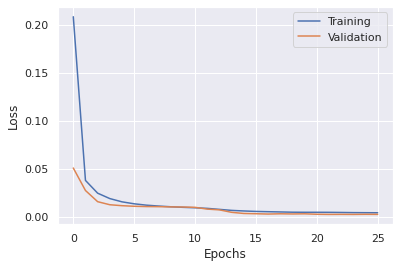

time: 742 ms (started: 2021-05-06 17:04:18 +00:00)


In [57]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation']);

##Evaluate

In [73]:
from sklearn.metrics import mean_squared_error
testGenerator.reset()
prediction = model.predict(testGenerator,
                     steps = len(testDataframe),verbose = 1)
groundTruth = testDataframe[['leftX', 'leftY', 'rightX', 'rightY']].to_numpy()
print(f'test loss: {mean_squared_error(groundTruth,prediction)}')

13041/13041 [==============================] - 56s 4ms/step
test loss: 0.009117938050483476
time: 56.4 s (started: 2021-05-06 18:10:24 +00:00)


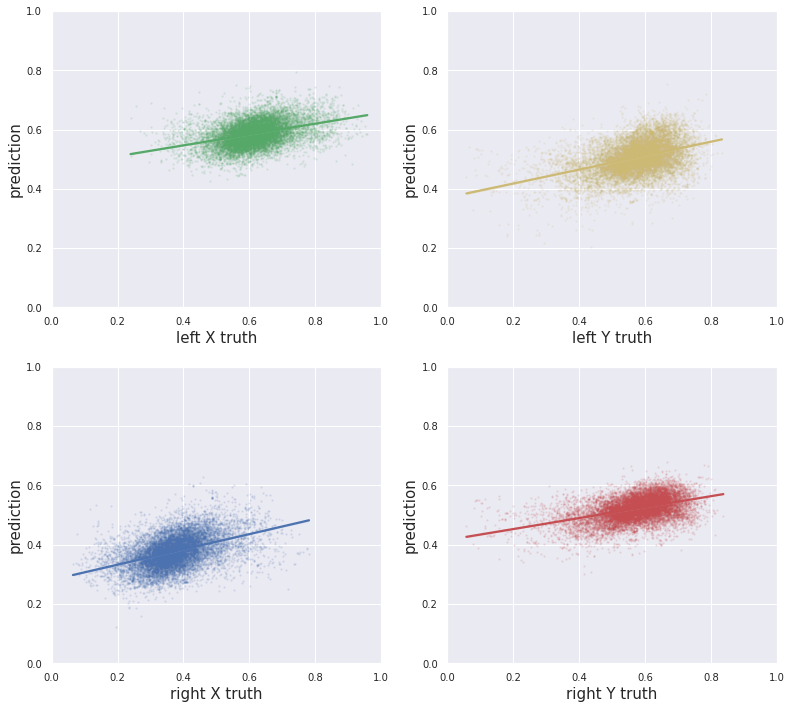

time: 5.5 s (started: 2021-05-06 18:11:20 +00:00)


In [74]:
import seaborn as sns

fig, axs = plt.subplots(nrows = 2,
                        ncols = 2,
                        figsize=(13,12))
sns.set_theme(color_codes=True)
plots = []
plots.append(sns.regplot(x = groundTruth[:,0], y = prediction[:,0], ax = axs[0,0], color = 'g', scatter_kws = {'s':2, 'alpha':0.1}))
plots.append(sns.regplot(x = groundTruth[:,1], y = prediction[:,1], ax = axs[0,1], color = 'y', scatter_kws = {'s':2, 'alpha':0.1}))
plots.append(sns.regplot(x = groundTruth[:,2], y = prediction[:,2], ax = axs[1,0], color = 'b', scatter_kws = {'s':2, 'alpha':0.1}))
plots.append(sns.regplot(x = groundTruth[:,3], y = prediction[:,3], ax = axs[1,1], color = 'r', scatter_kws = {'s':2, 'alpha':0.1}))
labels = ['left X truth', 'left Y truth', 'right X truth', 'right Y truth']
for i, plot in enumerate(plots):
  plot.set_xlabel(labels[i], fontsize = 15)
  plot.set_ylabel('prediction', fontsize = 15)
  plot.tick_params(labelsize = 10)
  plot.set(ylim=(0,1),xlim=(0,1))

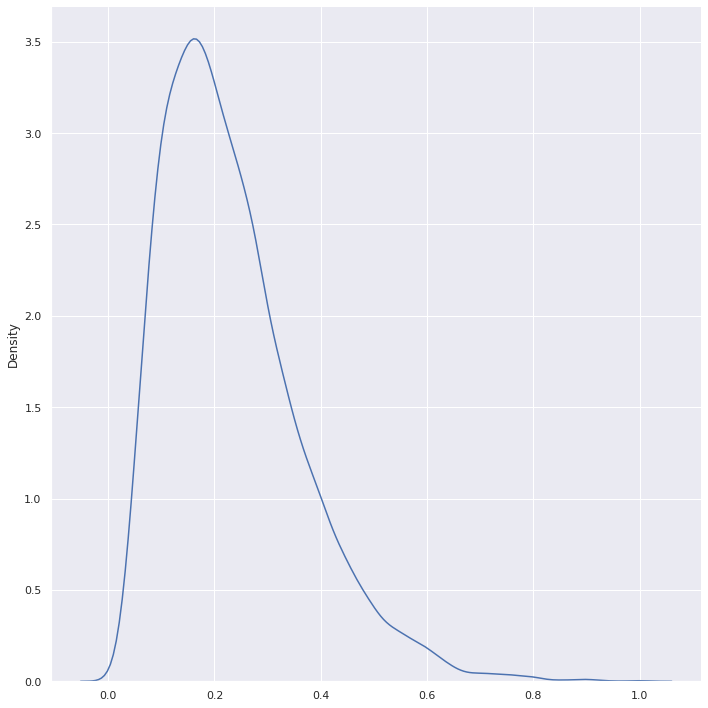

time: 1.34 s (started: 2021-05-06 18:11:26 +00:00)


In [75]:
losses = np.empty((groundTruth.shape[0],2), dtype=np.float32)
def dist(truth, pred):
  lt,rt = truth[[0,1]], truth[[2,3]]
  lp,rp = pred[[0,1]], pred[[2,3]]
  return np.linalg.norm(lt-lp) + np.linalg.norm(rt-rp)

for i in range(groundTruth.shape[0]):
  yTruth = groundTruth[i]
  yPred = prediction[i]
  losses[i][0] = dist(groundTruth[i],prediction[i])
  losses[i][1] = i
losses = losses[losses[:, 0].argsort()] #sort based on first column
sns.displot(losses[:,0],height=10,kind='kde')

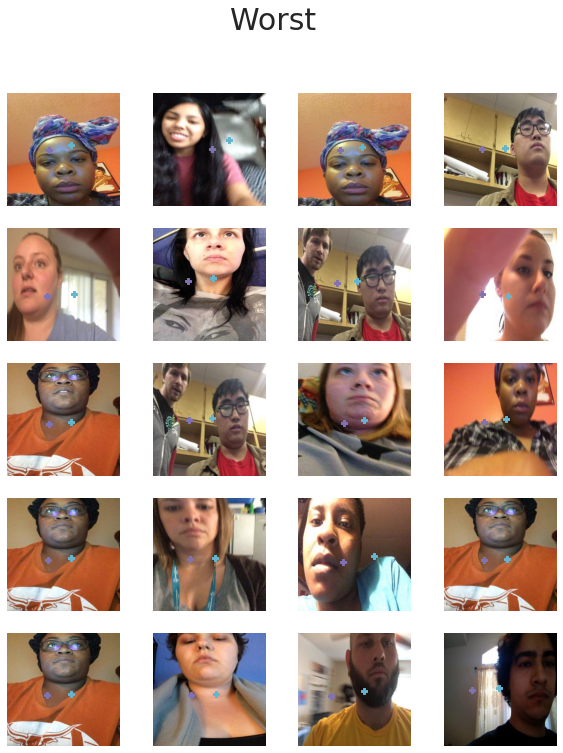

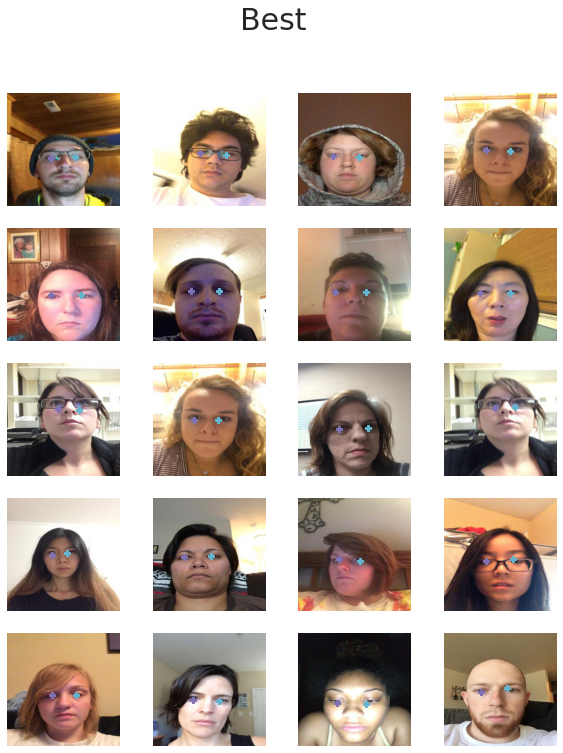

time: 8.82 s (started: 2021-05-06 18:11:27 +00:00)


In [76]:
def plotPictures(eyePositions, imagePaths, title):
  fig, axs = plt.subplots(5,4,False,False,figsize=(10,12))
  for i,path in enumerate(paths):
    with Image.open(path) as im:
      axs[i//4][i%4].imshow(im)
      left = eyePositions[i][[0,1]]*im.size
      right = eyePositions[i][[2,3]]*im.size
      axs[i//4][i%4].plot(left[0],left[1],marker='P',color='c')
      axs[i//4][i%4].plot(right[0],right[1],marker='P',color='m')
      axs[i//4][i%4].set_axis_off()
  fig.suptitle(title, fontsize=30)

worst = losses[-20:] #biggest losses
best = losses[:20] #smallest losses
indexes = np.rint(worst[:,1]).astype(int)  #get the indexes
paths = testDataframe.loc[indexes]['image'].to_numpy()
eyePositions = prediction[indexes]
plotPictures(eyePositions,paths, 'Worst')
indexes = np.rint(best[:,1]).astype(int)  #get the indexes
paths = testDataframe.loc[indexes]['image'].to_numpy()
eyePositions = prediction[indexes]
plotPictures(eyePositions,paths, 'Best')

##Save

In [ ]:
model.save('trackerNoMaxPoolEvenShorter.h5')